In [9]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
%matplotlib inline

In [10]:
# Dataset class
class PromptDataset(Dataset):
    def __init__(self, image_dir, prompt_file, tokenizer, transform=None, mode='train'):
        self.image_dir = image_dir
        self.prompt_file = prompt_file
        self.tokenizer = tokenizer
        self.transform = transform
        self.mode = mode
        # Load image filenames and corresponding text prompts
        self.data = []
        with open(prompt_file, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_name = row['imgId'] + ".png"  # Append the .png suffix
                prompt = row['prompt']
                self.data.append((os.path.join(image_dir, image_name), prompt))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, prompt = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.mode == 'train':
            inputs = self.tokenizer(prompt, return_tensors='pt', truncation=True, padding='max_length')
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            return image, inputs, prompt, image_path
        else:
            inputs = self.tokenizer(prompt, return_tensors='pt', truncation=True, padding='max_length')
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            return image, inputs, prompt, image_path

In [11]:
# Model definition
class ImageToPromptModel(nn.Module):
    def __init__(self, image_encoder, text_encoder, embedding_dim=768):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.fc = nn.Linear(image_encoder.fc.out_features, embedding_dim)

    def forward(self, images):
        image_features = self.image_encoder(images)
        image_embeddings = self.fc(image_features)
        return image_embeddings

In [12]:
# loss 
def mean_cosine_similarity_loss(predicted_embeddings, actual_embeddings):
    cosine_similarities = F.cosine_similarity(predicted_embeddings, actual_embeddings, dim=1)
    loss = 1 - cosine_similarities.mean()  # Lower loss is better
    return loss

In [13]:
def train(model, dataloader, optimizer, device='cuda'):
    model.train()
    model.to(device)
    total_loss = 0

    for images, inputs, _, _ in dataloader:
        images = images.to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        optimizer.zero_grad()
        predicted_embeddings = model(images)
        actual_embeddings = model.text_encoder(**inputs).pooler_output
        loss = mean_cosine_similarity_loss(predicted_embeddings, actual_embeddings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Training Loss: {avg_loss:.4f}")
    return avg_loss

In [14]:
# Evaluation and saving results
def evaluate_and_save_results(model, dataloader, device='cuda', output_csv='results.csv'):
    model.eval()
    model.to(device)

    # Open CSV file to write results
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image_name', 'cosine_similarity'])

        with torch.no_grad():
            for images, inputs, prompts, image_paths in dataloader:
                images = images.to(device)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Get predicted embeddings
                predicted_embeddings = model(images)

                # Get actual prompt embeddings
                actual_embeddings = model.text_encoder(**inputs).pooler_output

                # Calculate cosine similarity
                cosine_similarities = F.cosine_similarity(predicted_embeddings, actual_embeddings, dim=1)

                # Write to CSV file
                for image_path, similarity in zip(image_paths, cosine_similarities):
                    image_name = os.path.basename(image_path)
                    writer.writerow([image_name, similarity.item()])

    print(f"Results saved to {output_csv}")

Using cache found in C:\Users\24592/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/10


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Training Loss: 0.5046
Epoch 1 Training Loss: 0.5046
Best model saved!
Epoch 2/10
Training Loss: 0.0950
Epoch 2 Training Loss: 0.0950
Best model saved!
Epoch 3/10
Training Loss: 0.0489
Epoch 3 Training Loss: 0.0489
Best model saved!
Epoch 4/10
Training Loss: 0.0421
Epoch 4 Training Loss: 0.0421
Best model saved!
Epoch 5/10
Training Loss: 0.0180
Epoch 5 Training Loss: 0.0180
Best model saved!
Epoch 6/10
Training Loss: 0.0063
Epoch 6 Training Loss: 0.0063
Best model saved!
Epoch 7/10
Training Loss: 0.0032
Epoch 7 Training Loss: 0.0032
Best model saved!
Epoch 8/10
Training Loss: 0.0026
Epoch 8 Training Loss: 0.0026
Best model saved!
Epoch 9/10
Training Loss: 0.0023
Epoch 9 Training Loss: 0.0023
Best model saved!
Epoch 10/10
Training Loss: 0.0019
Epoch 10 Training Loss: 0.0019
Best model saved!
Results saved to test_results.csv


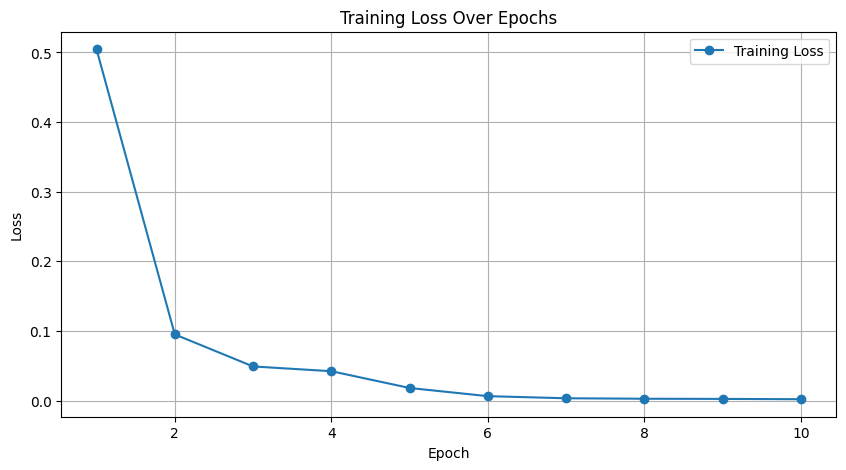

In [16]:
    train_image_dir = './data/images'
    train_prompt_file = './data/prompts.csv'
    test_image_dir = './data/images'
    test_prompt_file = './data/prompts.csv'

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    model_path = "./bert_localpath/"
    tokenizer = BertTokenizer.from_pretrained(model_path)
    text_encoder = BertModel.from_pretrained(model_path)

    train_dataset = PromptDataset(train_image_dir, train_prompt_file, tokenizer, transform=transform, mode='train')
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_dataset = PromptDataset(test_image_dir, test_prompt_file, tokenizer, transform=transform, mode='test')
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    image_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    model = ImageToPromptModel(image_encoder, text_encoder)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 10
    best_loss = float('inf')
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train(model, train_dataloader, optimizer, device=device)
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved!")

    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    model.to(device)

    output_csv = 'test_results.csv'
    similarities = evaluate_and_save_results(model, test_dataloader, device=device, output_csv=output_csv)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
def plot_images_with_similarity(csv_file, image_dir, num_samples=6):

    # 加载 CSV 文件
    data = pd.read_csv(csv_file)
    image_names = data['image_name'].tolist()
    similarities = data['cosine_similarity'].tolist()

    # 选取指定数量的样本
    num_samples = min(num_samples, len(image_names))
    selected_images = image_names[:num_samples]
    selected_similarities = similarities[:num_samples]

    # 设置绘图区域
    plt.figure(figsize=(15, 10))  # 根据需要调整大小

    # 绘制图片
    for idx, (image_name, similarity) in enumerate(zip(selected_images, selected_similarities)):
        # 加载图片
        image_path = f"{image_dir}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        # 设置子图
        plt.subplot(2, 3, idx + 1)  # 2行3列布局
        plt.imshow(image)
        plt.title(f"Cosine Similarity: {similarity:.4f}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

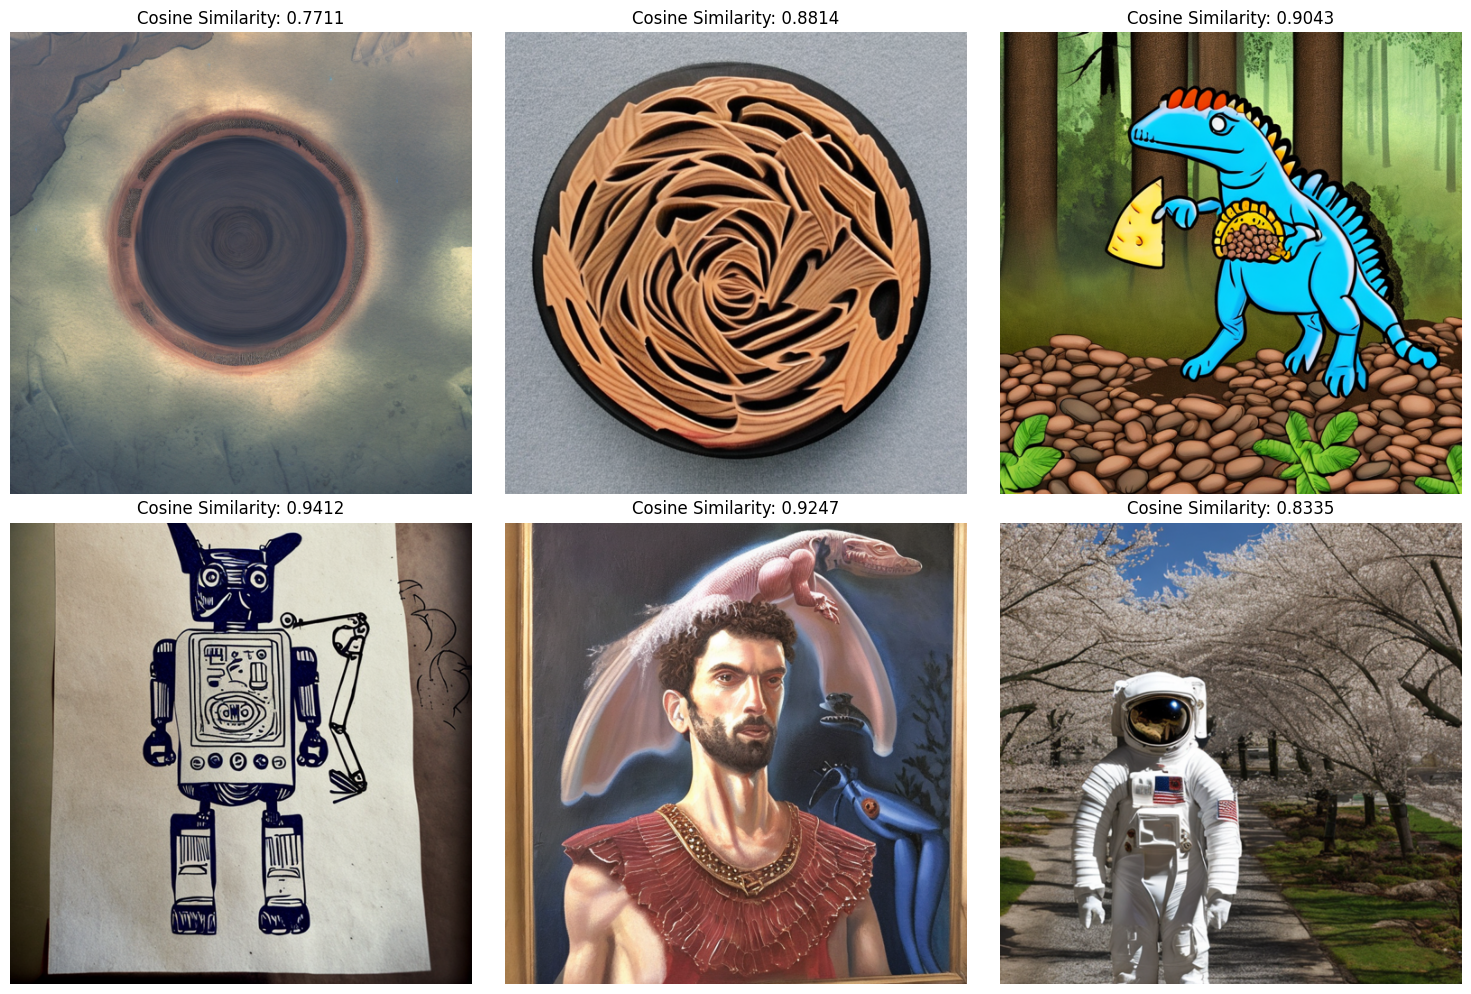

In [18]:
csv_file = 'test_results.csv'
image_dir = './data/images'  
plot_images_with_similarity(csv_file, image_dir, num_samples=6)